# Processing of the raw count matrices

In this notebook, we concatenate and pre-process the raw count matrices of single nuclei RNAseq data.  
- Full transcripts,
- aggregated in genes,
- intersection non empty

raw file names (control data) in subdirectory `normal`: 
- data produced in UK: `raw_count_mat_transcripts_aggregated_in_genes_intersection_nonempty.txt`
- data produced in Munich: `raw_count_mat_2p_transcripts_to_genes_intersection_nonempty.txt`
- data produced at DKFZ: 
    - `raw_count_mat_634_transcripts_to_genes_intersection_nonempty.txt` 
    - `raw_count_mat_635_transcripts_to_genes_intersection_nonempty.txt` 
    - `raw_count_mat_626_transcripts_to_genes_intersection_nonempty.txt`

Maria Richter has concatenated these files already in an `anndata` object.

raw file names (knock-out data) in subdirectory `knock_outs`:
- data produced in UK: `raw_count_mat_ko_transcripts_to_genes_intersection_nonempty.txt`

raw file names (knock-out data) in subdirectory `ko_HNF4`:
- data produced in UK(?): `raw_count_mat_HNF4_transcripts_to_genes_intersection_nonempty.txt`

raw file names (knock-out data) in subdirectory `ko_DKFZ_621`:
- data produced at DKFZ: `raw_count_mat_HNF4_transcripts_to_genes_intersection_nonempty.txt`

raw file names (knock-out data) in subdirectory `ko_DKFZ_630`:
- data produced at DKFZ: `raw_count_mat_HNF4_transcripts_to_genes_intersection_nonempty.txt`

raw file names (knock-out data) in subdirectory `ko_DKFZ_631`:
- data produced at DKFZ: `raw_count_mat_HNF4_transcripts_to_genes_intersection_nonempty.txt`

It must be noted that the naming `HNF4` is due to a naming issue and not associated with the actual knockout.

raw file names (knock-out data) in subdirectory `ageing_ko_cruk_jan21`: six more plates from both old and young mice with the knock-out condition.
- subdirectory `SLX-19028`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`
- subdirectory `SLX-19501`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`
- subdirectory `SLX-19502`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`
- subdirectory `SLX-19503`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`
- subdirectory `SLX-19504`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`
- subdirectory `SLX-19545`: `raw_count_mat_transcripts_to_genes_intersection_nonempty.txt`

Instead, the samples belong to the following conditions:

|sample name (mapping) | sample ID (plate) | condition| ERCC dilution |
|--|--|--|--|
|DKFZ 621| SNI-621 | CEBPA |1:300.000 |
|DKFZ 630| SNI-630 | CTCF | 1:300.000|
|DKFZ 631| SNI-631 | HNF4 |1:300.000 |
|knock-outs | SNI-196 | CTCF | 1:100.000|
|knock-outs | SNI-171(R3)| CEPBA| 1:100.000|
|knock-outs | SNI-236(R2) | CEBPA| 1:100.000|
|ko_HNF4 | SNI-195 | HNF4 |1:100.000 |
|SLX-19501| SNI-651 | HNF4|1:100.000 |
|SLX-19502| SNI-652	| CTCF|1:100.000 |
|SLX-19503| SNI-653	| CEBPA|1:100.000 |
|SLX-19504| SNI-664	| HNF4|1:100.000 |
|SLX-19505| SNI-665	| CTCF|1:100.000 |
|SLX-19028| SNI-667	| CEBPA |1:100.000 |

In the "normal" data, we have several replicates of black 6 mice (sample IDs in sample table and metadata: SNI-160(2), SNI-193, SNI-194, SNI-116(R2), SNI-192p1, SNI-192p2, SNI-634, SNI-635, SNI-626, SNI-234(R2), SNI-235(R2)).

In [1]:
def cell_compo_table(adata, cluster, condition, xlabel='cell cluster',
                        ylabel='cell count', title=None, save=False):
    """
    """
    

    contingency_table = pd.crosstab(
        adata.obs[condition],
        adata.obs[cluster],
        margins = True
    )
    return(contingency_table)

def top_marker_as_xlsx(adata, key_rank_genes, key_groups, output_file):
    
    print(adata.uns[key_rank_genes].keys())
    dict_genes = adata.uns[key_rank_genes].copy()
    print(dict_genes['params'])
    del dict_genes['params']
    clusters = sorted(list(set(adata.obs[key_groups])))*len(dict_genes['scores'])
    for key, value in dict_genes.items():
        tmp_list = []
        for n in value:
            tmp_list = tmp_list + list(n)
        dict_genes[key] = tmp_list
    
    dict_genes['cluster'] = clusters

    dataframe = pd.DataFrame(dict_genes)
    dataframe.to_excel(output_file)
    return(dataframe)

In [2]:
## import library used for the analysis
import scanpy as sc
import anndata as ad
import numpy as np
import scipy.io as sci
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib import rcParams

In [155]:
from datetime import date

today = date.today().strftime("%y%m%d")

In [3]:
## set paramteres for visualisation

sc.settings.set_figure_params(dpi=80)

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

In [4]:
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.1
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.0
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.3
mpl_toolkits        NA
natsort             7.1.0
numba               0.52.0
numexpr             2.7.1
numpy               1.19.4
packaging           20.8
pandas              1.1.5
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptyprocess          0.6.0
pygments            2.7.3
pyp

# Load data

In [5]:
## define paths
projectdir ='/storage/groups/ml01/workspace/maren.buettner/Martinez_Liver_HPC/'
datadir = projectdir + 'data' #local
file_path_normal = os.path.join(datadir, 'normal/') #data mapped by Maria Richter
file_path_ko = os.path.join(datadir, 'knock_outs/') #data mapped by Maria Richter
file_path_HNF4 = os.path.join(datadir, 'ko_HNF4/')
file_path_621 = os.path.join(datadir, 'ko_DKFZ_621/')
file_path_630 = os.path.join(datadir, 'ko_DKFZ_630/')
file_path_631 = os.path.join(datadir, 'ko_DKFZ_631/')
file_path_19028 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19028/')
file_path_19501 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19501/')
file_path_19502 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19502/')
file_path_19503 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19503/')
file_path_19504 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19504/')
file_path_19505 = os.path.join(datadir, 'ageing_ko_cruk_jan21/SLX-19505/')

Let us look at the metadata file for the normal samples.

In [6]:
metadata = pd.read_csv(datadir + '/' + 'metadata_all_plates_jan20_new_ERCC.txt', sep='\t')

In [7]:
metadata['exp.'].value_counts()

SNI-194        384
SNI-235(R2)    384
SNI-234(R2)    384
SNI-635        384
SNI-192-p1     384
SNI-634        384
SNI-116(R2)    384
SNI-192-p2     384
SNI-626        384
SNI-193        384
SNI-160(R2)    384
Name: exp., dtype: int64

In [8]:
metadata.head()

,Sample,Mapped,ERCC,Endogenous,exp.,Sort,LibraryID,Experiment,Genome,Strain,...,Nextera.XT...384.CDIs,Index.i7,Index.i5,LPP.Frag..Size..bp.,Submitted.Conc...nM.,Submitted.Vol...ul.,column,row,LIMS,percentERCC
0,do22693,2525931,566591.0,3918680,SNI-160(R2),NaN,CM-SNI-160(R2) -1-A,CM-SNI-160(R2) -1-A,Mouse(mm10),C57Bl6/J,...,Nextera XT - 384 CDIs,i701,i502,NaN,NaN,NaN,1,A,MAR14001A1,0.224310
1,do22694,1408066,237273.0,2341586,SNI-160(R2),NaN,CM-SNI-160(R2)-1-B,CM-SNI-160(R2)-1-B,Mouse(mm10),C57Bl6/J,...,Nextera XT - 384 CDIs,i702,i502,NaN,NaN,NaN,1,B,MAR14001A2,0.168510
2,do22695,2287604,405307.0,3764594,SNI-160(R2),NaN,CM-SNI-160(R2)-1-C,CM-SNI-160(R2)-1-C,Mouse(mm10),C57Bl6/J,...,Nextera XT - 384 CDIs,i701,i503,NaN,NaN,NaN,1,C,MAR14001A3,0.177175
3,do22696,594271,108264.0,972014,SNI-160(R2),NaN,CM-SNI-160(R2)-1-D,CM-SNI-160(R2)-1-D,Mouse(mm10),C57Bl6/J,...,Nextera XT - 384 CDIs,i702,i503,NaN,NaN,NaN,1,D,MAR14001A4,0.182180
4,do22697,29574,8520.0,42108,SNI-160(R2),NaN,CM-SNI-160(R2)-1-E,CM-SNI-160(R2)-1-E,Mouse(mm10),C57Bl6/J,...,Nextera XT - 384 CDIs,i701,i505,NaN,NaN,NaN,1,E,MAR14001A5,0.288091


Let us load the metadata file of the knock-out data.

In [127]:
tmps = []    
for sheet in ['SNI-621', 'SNI-630', 'SNI-631', 'SNI-196','SNI-171 (R3)','SNI-236 (R2)','SNI-195', 'SNI-651', 'SNI-652', 'SNI-653', 'SNI-664', 'SNI-665', 'SNI-667']:
    tmp = pd.read_excel(datadir + '/' + 'Libraries_KOs_Layout_ScLib_210111_MB.xlsx', 
                        sheet_name=sheet)
    tmps.append(tmp)
metadata_KO = pd.concat(tmps, sort=False)

In [128]:
metadata_KO.shape

(4992, 21)

In [131]:
metadata_KO.loc[metadata_KO['exp.']=='SNI-171(R3)']

,exp.,plate,Specie/strain,condtition,age,mice ID,Solexa,CM number,code,HiSeq,...,column,raw,indexes,index,index.1,index.2,index.3,indexes.1,LIMS,DO number
0,SNI-171(R3),1,CEBPA KO,2n,3 mo,17/012752 (SNI-71),SLX-14324,NaN,CM-SNI-171(R3)-1-A,HiSeq4000,...,1,A,N701-S502,N701,S502,i701,i502,i701-i502,MAR14004A1537,DO23461
1,SNI-171(R3),1,CEBPA KO,2n,3 mo,17/012752 (SNI-71),SLX-14324,NaN,CM-SNI-171(R3)-1-B,HiSeq4000,...,1,B,N702-S502,N702,S502,i702,i502,i702-i502,MAR14004A1538,DO23462
2,SNI-171(R3),1,CEBPA KO,2n,3 mo,17/012752 (SNI-71),SLX-14324,NaN,CM-SNI-171(R3)-1-C,HiSeq4000,...,1,C,N701-S503,N701,S503,i701,i503,i701-i503,MAR14004A1539,DO23463
3,SNI-171(R3),1,CEBPA KO,2n,3 mo,17/012752 (SNI-71),SLX-14324,NaN,CM-SNI-171(R3)-1-D,HiSeq4000,...,1,D,N702-S503,N702,S503,i702,i503,i702-i503,MAR14004A1540,DO23464
4,SNI-171(R3),1,CEBPA KO,4n,3 mo,17/012752 (SNI-71),SLX-14324,NaN,CM-SNI-171(R3)-1-E,HiSeq4000,...,1,E,N701-S505,N701,S505,i701,i505,i701-i505,MAR14004A1541,DO23465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,SNI-171(R3),1,CEBPA KO,2n,23 mo,15/010200 (SNI-31),SLX-14324,NaN,CM-SNI-171(R3)-24-L,HiSeq4000,...,24,L,N729-S520,N729,S520,i729,i520,i729-i520,MAR14004A1916,DO23840
380,SNI-171(R3),1,CEBPA KO,4n,23 mo,15/010200 (SNI-31),SLX-14324,NaN,CM-SNI-171(R3)-24-M,HiSeq4000,...,24,M,N728-S521,N728,S521,i728,i521,i728-i521,MAR14004A1917,DO23841
381,SNI-171(R3),1,CEBPA KO,4n,23 mo,15/010200 (SNI-31),SLX-14324,NaN,CM-SNI-171(R3)-24-N,HiSeq4000,...,24,N,N729-S521,N729,S521,i729,i521,i729-i521,MAR14004A1918,DO23842
382,SNI-171(R3),1,CEBPA KO,4n,23 mo,15/010200 (SNI-31),SLX-14324,NaN,CM-SNI-171(R3)-24-O,HiSeq4000,...,24,O,N728-S522,N728,S522,i728,i522,i728-i522,MAR14004A1919,DO23843


Let us look at the cell type marker file:

In [12]:
markers = pd.read_table(datadir + '/' + 'cell_type_markers_curated.csv', header=None)

In [13]:
markers.head()

,0,1,2
0,Krt14,Cholangiocyte,Hepatobiliary
1,Krt19,Cholangiocyte,Hepatobiliary
2,Sptbn1,Cholangiocyte,Hepatobiliary
3,Krt9,Cholangiocyte,Hepatobiliary
4,Krt7,Cholangiocyte,Hepatobiliary


## Normal condition

Maria Richter has concatenated the normal data already in an `anndata` object.

In [14]:
adata_normal = sc.read(file_path_normal + 'snRNAseq_mouse_hepatocytes_all_cells_apr20_raw.h5ad')

In [15]:
adata_normal

AnnData object with n_obs × n_vars = 4224 × 54329
    obs: 'batch', 'Sample', 'Mapped', 'ERCC', 'Endogenous', 'exp.', 'Sort', 'LibraryID', 'Experiment', 'Genome', 'Strain', 'ID.Individual', 'Tissue', 'Age', 'Sex', 'Ploidy', 'TissueProcessing', 'Projects', 'AssayType', 'Protocol', 'Platform', 'ERCC.dilution', 'ERCC.Vol..in.RT.Vol.', 'ERCC.Lot.number', 'Seq_Tube_ID', 'Seq.Type', 'Sequencer', 'Nextera.XT...384.CDIs', 'Index.i7', 'Index.i5', 'LPP.Frag..Size..bp.', 'Submitted.Conc...nM.', 'Submitted.Vol...ul.', 'column', 'row', 'LIMS', 'percentERCC\n'
    var: 'length', 'gene_name', 'chromosomes', 'start', 'end'

In [16]:
adata_normal.obs['exp.'].value_counts()

SNI-635        384
SNI-634        384
SNI-626        384
SNI-235(R2)    384
SNI-234(R2)    384
SNI-194        384
SNI-193        384
SNI-192-p2     384
SNI-192-p1     384
SNI-160(R2)    384
SNI-116(R2)    384
Name: exp., dtype: int64

In [17]:
adata_normal.obs['Ploidy'].value_counts()

2n      2092
4n      2062
-         50
2-2n      20
Name: Ploidy, dtype: int64

In [18]:
adata_normal.obs['Age'].value_counts()

3 months       2496
22 months      1152
22.5 months     576
Name: Age, dtype: int64

In [19]:
pd.crosstab(adata_normal.obs['Ploidy'], adata_normal.obs['Age'])

Age,3 months,22 months,22.5 months
Ploidy,,,
2-2n,20,0,0
2n,1228,576,288
4n,1198,576,288
-,50,0,0


## Knock-out condition 

Let us read in the knock-out data, which were mapped by Maria Richter. 

In [20]:
raw_mtx_1 = 'raw_count_mat_ko_transcripts_to_genes_intersection_nonempty.txt'


## Load the data 
count_mat = []
gene_names = []
transcript_ids = []

with open(file_path_ko + raw_mtx_1) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
            
        line[-1] = line[-1][:-1]
        transcript_ids.append(line[0])
        gene_names.append(line[1])
        count_mat.append(line[2:])

In [21]:
## transform the raw count matrix to be in a data format compatible with AnnData
count_mat = np.matrix(count_mat)
count_mat = count_mat.transpose()
count_mat.shape

(1152, 54329)

In [22]:
count_mat = np.array(count_mat)

Next, I would have to annotate the data (giving it `obs_names` and `var_names`).

Load sample name, it will be `obs_names` in the AnnData object.

In [23]:
cell_names = []
with open(file_path_ko + "ko_cell_names1.txt") as f:
    for line in f:
        line = line.split(".")
        line = line[0].split("\n")
        cell_names.append(line[0])

### Load annotation - metadata

load gene information used to build the count matrix:
- mouse mm10 - mmGRCm38.93 
- additional 92 ERCC used for spike in

The data load will be used for `var_names` and variable metadata in the AnnData object.

In [24]:
# load the gene annotation/gtf file
chromosome = []
start = []
end = []
infos = []
with open(projectdir + "code/mmGRCm38.93.ERCC92.transcript.gtf") as f:
    for line in f:
        line = line.split("\t")
        if len(line) > 1:
            if len(line) > 2 and line[2] == "transcript":
                chromosome.append(line[0])
                start.append(line[3])
                end.append(line[4])
                infos.append(line[8])
                

In [25]:
# extract the gene_id from the loaded gtf file
gene = []
for elem in infos:
    elem = elem.split(";")
    elem[0] = elem[0].replace('"', '')
    elem[1] = elem[1].replace('"', '')
    if elem[0].split(" ")[0] == "gene_id":
        gene.append(elem[0].split(" ")[1])

In [26]:
# extract the transript size
chrom_dict = {}
start_dict = {}
end_dict = {}
for i in range(0,len(gene)):
    chrom_dict[gene[i]] = chromosome[i]
    start_dict[gene[i]] = start[i]
    end_dict[gene[i]] = end[i]

In [27]:
# format the data to load then as variable annotation in the AnnData object
gene_dict = {}
starts = {}
ends = {}
for i in range(0,len(transcript_ids)):
    if transcript_ids[i] in chrom_dict.keys():
        gene_dict[transcript_ids[i]] = chrom_dict[transcript_ids[i]]
        starts[transcript_ids[i]] = start_dict[transcript_ids[i]]
        ends[transcript_ids[i]] = end_dict[transcript_ids[i]]
    else:
        gene_dict[transcript_ids[i]] = -1
        starts[transcript_ids[i]] = -1
        ends[transcript_ids[i]] = -1

### Create the AnnData object for the analysis

It only contains the first part of the data (knock-outs mapped by Maria Richter).

In [28]:
adata_ko = ad.AnnData(count_mat, 
                   obs=pd.DataFrame(index=cell_names),
                   var=pd.DataFrame(index=transcript_ids))

In [29]:
adata_ko

AnnData object with n_obs × n_vars = 1152 × 54329

### Load the annotation to the adata object

In [30]:
adata_ko.var["gene_name"] = gene_names # load gene_name
adata_ko.var["chromosomes"] = gene_dict.values() # load chromosome where the gene is

# load starting position of the transcripts
adata_ko.var["start"] = starts.values()
adata_ko.var["start"] = pd.to_numeric(adata_ko.var["start"])
# load end position of the transcripts
adata_ko.var["end"] = ends.values()
adata_ko.var["end"] = pd.to_numeric(adata_ko.var["end"])

# add length of the transcripts
length = adata_ko.var["end"] - adata_ko.var["start"]
adata_ko.var["length"] = length

Overview of the loaded data.

In [31]:
adata_ko

AnnData object with n_obs × n_vars = 1152 × 54329
    var: 'gene_name', 'chromosomes', 'start', 'end', 'length'

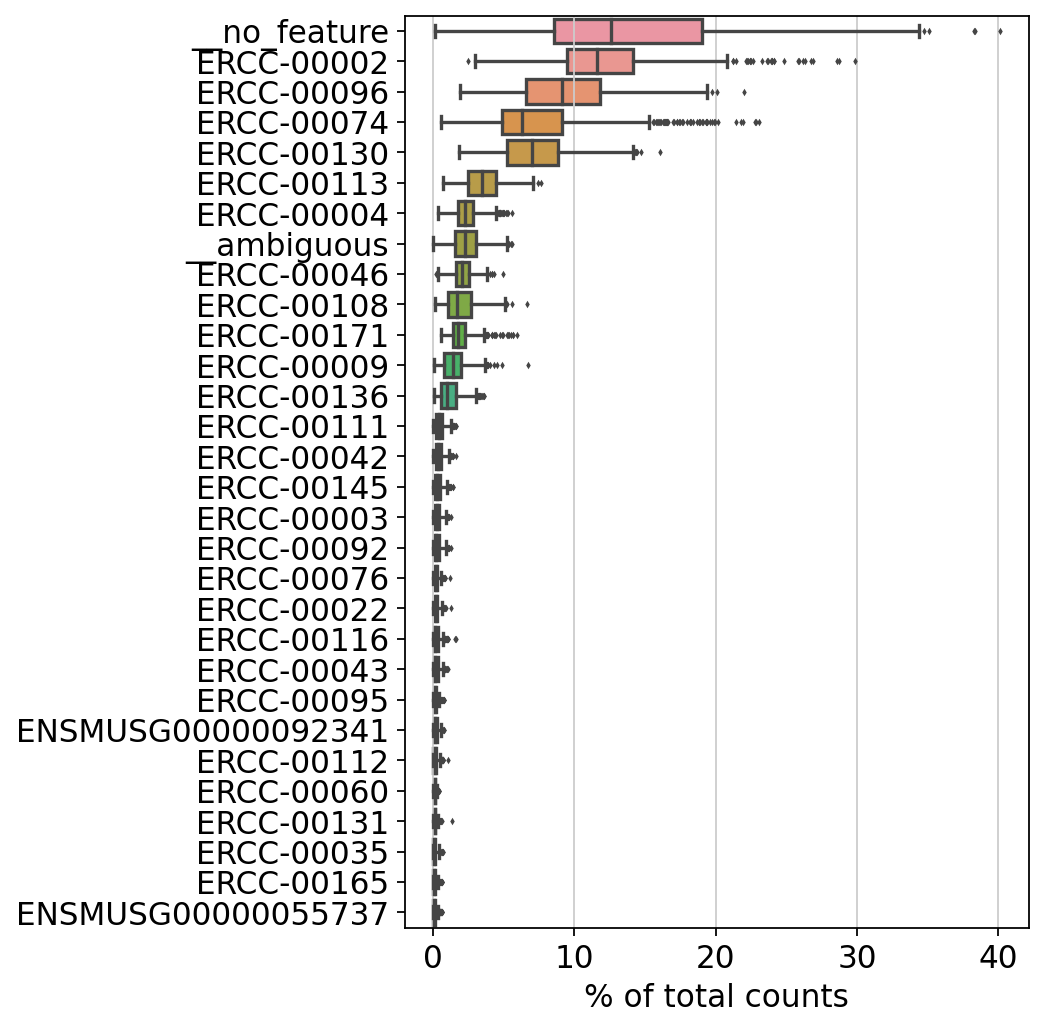

In [32]:
sc.pl.highest_expr_genes(adata_ko)

## Load second set of knock-out data
Here, we load the mapped data by Maren Büttner (created with the same scripts, parameters and genomes as used by Maria Richter). 

In [88]:
## define path and matrix

sample_dir_0 = os.path.join(datadir, 'ko_DKFZ_621/')
sample_dir_1 = os.path.join(datadir, 'ko_DKFZ_630/')
sample_dir_2 = os.path.join(datadir, 'ko_DKFZ_631/')
sample_dir_3 = os.path.join(datadir, 'ko_HNF4/')

raw_mtx_0 = 'raw_count_mat_HNF4_transcripts_to_genes_intersection_nonempty.txt' #name happened to be always the same


## Load the data 
count_mat = []
count_mat2 = []
count_mat3 = []
count_mat4 = []
gene_names = []
transcript_ids = []

with open(sample_dir_0 + raw_mtx_0) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
            
        line[-1] = line[-1][:-1]
        transcript_ids.append(line[0])
        gene_names.append(line[1])
        count_mat.append(line[2:])

with open(sample_dir_1 + raw_mtx_0) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat2.append(line[2:])    
        
with open(sample_dir_2 + raw_mtx_0) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat3.append(line[2:])           
        
with open(sample_dir_3 + raw_mtx_0) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat4.append(line[2:])   

In [89]:
count_mat = np.array(count_mat)
count_mat = count_mat.transpose()
count_mat.shape

(384, 54329)

In [90]:
count_mat2 = np.array(count_mat2)
count_mat2 = count_mat2.transpose()
count_mat2.shape

(385, 54329)

In [91]:
count_mat3 = np.array(count_mat3)
count_mat3 = count_mat3.transpose()
count_mat3.shape

(385, 54329)

In [92]:
count_mat4 = np.array(count_mat4)
count_mat4 = count_mat4.transpose()
count_mat4.shape

(384, 54329)

In [93]:
count_mat = np.append(count_mat, count_mat2, axis=0)
count_mat = np.append(count_mat, count_mat3, axis=0)
count_mat = np.append(count_mat, count_mat4, axis=0)

In [94]:
count_mat.shape

(1538, 54329)

Note to self: Keeping the `cell_names.txt` file together with the fastq files is a bad idea because it might be mistaken as input file.

Let us check which of the entries is exactly zero to remove it.

In [95]:
count_mat3

array([['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ...,
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['1', '0', '0', ..., '0', '0', '0']], dtype='<U6')

In [96]:
adata_tmp = ad.AnnData(count_mat3, 
                        #obs=pd.DataFrame(index=cell_names1),
                        var=pd.DataFrame(index=transcript_ids))

In [97]:
adata_tmp.obs['n_counts']= adata_tmp.X.sum(1)

In [98]:
np.flatnonzero(adata_tmp.obs['n_counts']==0)

array([0])

In [99]:
adata_tmp.obs['n_counts']==0

0       True
1      False
2      False
3      False
4      False
       ...  
380    False
381    False
382    False
383    False
384    False
Name: n_counts, Length: 385, dtype: bool

It turns out that the first entry in the count matrix `count_mat3` belongs to the `cell_names.txt` file. Let us add it to the naming.

In [100]:
# load cell names
cell_names0 = []
with open(sample_dir_0 + 'cell_names.txt') as f: #SNI-621
    for line in f:
        line = line.split(".")
        cell_names0.append(line[0][:-1])

cell_names1 = []
with open(sample_dir_1 + 'cell_names.txt') as f: #SNI-630
    for line in f:
        line = line.split(".")
        cell_names1.append(line[0][:-1])

cell_names2 = ['cell_name']
with open(sample_dir_2 + 'cell_names.txt') as f: #SNI-631
    for line in f:
        line = line.split(".")
        cell_names2.append(line[0][:-1])

cell_names3 = []
with open(sample_dir_3 + 'knock_out_HNF4_cell_names.txt') as f: #SNI-195
    for line in f:
        line = line.split(".")
        cell_names3.append(line[0][:-1])

In [101]:
print(len(cell_names0))
print(len(cell_names1))
print(len(cell_names2))
print(len(cell_names3))

384
385
385
384


Next, all sample names belong to the plate position rather than a sample-specific cell ID. We'll have to adapt that as well.

In [102]:
cell_names1[:5]

['cell_name', 'healthy-10-a', 'healthy-10-b', 'healthy-10-c', 'healthy-10-d']

In the metadata, the `healthy-00-A` names are encoded as `ID-SNI-6XY-00-A`. Thus, we adapt the cell names in every sample and add `ID-SNI-XYZ` and capitalize the letters.

The `knock_out_HNF4` sample provides 'DO' numbers for each samples, so we will use those.

In [103]:
cell_names0_adjust = []
for names in cell_names0:
    if names.startswith('healthy'):
        tmp = names.split('-')
        new_names = 'ID-SNI-621-' + tmp[1] + '-' + tmp[2].upper()
        cell_names0_adjust.append(new_names)
    else:
        cell_names0_adjust.append(names)

In [104]:
cell_names1_adjust = []
for names in cell_names1:
    if names.startswith('healthy'):
        tmp = names.split('-')
        new_names = 'ID-SNI-630-' + tmp[1] + '-' + tmp[2].upper()
        cell_names0_adjust.append(new_names)
    else:
        cell_names0_adjust.append(names)

cell_names2_adjust = []
for names in cell_names2:
    if names.startswith('healthy'):
        tmp = names.split('-')
        new_names = 'ID-SNI-631-' + tmp[1] + '-' + tmp[2].upper()
        cell_names2_adjust.append(new_names)
    else:
        cell_names2_adjust.append(names)

In [105]:
cell_names3_adjust = []
for names in cell_names3:
    if names.startswith('healthy'):
        tmp = names.split('-')
        new_names = 'CM-SNI-195-' + tmp[1] + '-' + tmp[2].upper()
        cell_names3_adjust.append(new_names)
    else:
        cell_names3_adjust.append(names.lower())

Concatenate the cell names and create Anndata object.

In [106]:
cell_names_adjust = cell_names0_adjust + cell_names1_adjust + cell_names2_adjust + cell_names3_adjust

In [107]:
len(cell_names_adjust)

1538

In [108]:
adata_DKFZ = ad.AnnData(count_mat, 
                        obs=pd.DataFrame(index=cell_names_adjust),
                        var=pd.DataFrame(index=transcript_ids))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Remove the empty extra columns.

In [109]:
print(adata_DKFZ.n_obs)

1538


In [110]:
sc.pp.filter_cells(adata_DKFZ, min_counts=10)

In [111]:
print(adata_DKFZ.n_obs)

1536


## Load third set of knock-out data

Here, we load an additional set of six plates of knock-out data mapped data by Maren Büttner (created with the same scripts, parameters and genomes as used by Maria Richter). 

In [33]:
## define path and matrix
file_path_ko = os.path.join(datadir, 'ageing_ko_cruk_jan21')
file_path_19028 = os.path.join(file_path_ko, 'SLX-19028/')
file_path_19501 = os.path.join(file_path_ko, 'SLX-19501/')
file_path_19502 = os.path.join(file_path_ko, 'SLX-19502/')
file_path_19503 = os.path.join(file_path_ko, 'SLX-19503/')
file_path_19504 = os.path.join(file_path_ko, 'SLX-19504/')
file_path_19505 = os.path.join(file_path_ko, 'SLX-19505/')

raw_mtx = 'raw_count_mat_transcripts_to_genes_intersection_nonempty.txt' #name happened to be always the same


## Load the data 
count_mat_19028 = []
count_mat_19501 = []
count_mat_19502 = []
count_mat_19503 = []
count_mat_19504 = []
count_mat_19505 = []
gene_names = []
transcript_ids = []

with open(file_path_19028 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
            
        line[-1] = line[-1][:-1]
        transcript_ids.append(line[0])
        gene_names.append(line[1])
        count_mat_19028.append(line[2:])

with open(file_path_19501 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat_19501.append(line[2:])    
        
with open(file_path_19502 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat_19502.append(line[2:])           
        
with open(file_path_19503 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat_19503.append(line[2:])   
        
        
with open(file_path_19504 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat_19504.append(line[2:])           
        
with open(file_path_19505 + raw_mtx) as f:
    for line in f:
        line = line.split("\t")
        for elem in line:
            elem = elem.split(";")
           
        line[-1] = line[-1][:-1]
        #transcript_ids.append(line[0])
        #gene_names.append(line[1])
        count_mat_19505.append(line[2:])   

In [34]:
count_mat_19028 = np.array(count_mat_19028)
count_mat_19028 = count_mat_19028.transpose()
count_mat_19028.shape

(384, 54329)

In [35]:
count_mat_19501 = np.array(count_mat_19501)
count_mat_19501 = count_mat_19501.transpose()
count_mat_19501.shape

(384, 54329)

In [36]:
count_mat_19502 = np.array(count_mat_19502)
count_mat_19502 = count_mat_19502.transpose()
count_mat_19502.shape

(384, 54329)

In [37]:
count_mat_19503 = np.array(count_mat_19503)
count_mat_19503 = count_mat_19503.transpose()
count_mat_19503.shape

(384, 54329)

In [38]:
count_mat_19504 = np.array(count_mat_19504)
count_mat_19504 = count_mat_19504.transpose()
count_mat_19504.shape

(384, 54329)

In [39]:
count_mat_19505 = np.array(count_mat_19505)
count_mat_19505 = count_mat_19505.transpose()
count_mat_19505.shape

(384, 54329)

In [40]:
count_mat_19501 = np.append(count_mat_19501, count_mat_19502, axis=0)
count_mat_19501 = np.append(count_mat_19501, count_mat_19503, axis=0)
count_mat_19501 = np.append(count_mat_19501, count_mat_19504, axis=0)
count_mat_19501 = np.append(count_mat_19501, count_mat_19505, axis=0)
count_mat_19501 = np.append(count_mat_19501, count_mat_19028, axis=0)

In [41]:
count_mat_19501.shape

(2304, 54329)

In those samples, the cell names were always the same and stored in `ageing_ko_cruk_jan21/cell_names.txt` file. 
The cell names from the mapping are the same for all cells (i.e. the barcode sequence for each cell). In the raw data directory, we have stored the plate ID information, which we will map using the cell names.

In [45]:
raw_data_dir = '/storage/groups/ml01/datasets/raw/20200601_MartinezLiverKO_maren.buettner/ageing_ko_cruk_jan21/'
fileID = os.listdir(raw_data_dir)
meta_fileID = [files for files in fileID if files.endswith('contents.csv')]

In [46]:
meta_fileID

['SLX-19503.HK7FGBBXY.s_4.contents.csv',
 'SLX-19502.HK7FGBBXY.s_3.contents.csv',
 'SLX-19501.HK7FGBBXY.s_2.contents.csv',
 'SLX-19504.HK7FGBBXY.s_5.contents.csv',
 'SLX-19505.HK7FGBBXY.s_6.contents.csv',
 'SLX-19028.HK7FGBBXY.s_1.contents.csv']

In [47]:
# load cell names
cell_names = []
with open(raw_data_dir + 'cell_names.txt') as f: #SNI-621
    for line in f:
        line = line.split(".")
        cell_names.append(line[0][:-1])



In [48]:
print(len(cell_names))

384


In [49]:
cell_names[:5]

['i719_i518', 'i723_i505', 'i718_i506', 'i705_i511', 'i726_i515']

Load the metadata tables for the six plates (see `meta_fileID`). 

In [78]:
cell_name_plate = {}
for files in meta_fileID:
    print(files)
    tmp = pd.read_csv(raw_data_dir + files)
    idx_order = [np.flatnonzero(tmp['Barcode']==names.replace('_', '-'))[0] for names in cell_names]
    cell_name_plate[tmp['Pool'][0]] = tmp['Sample name'][idx_order].values
    print(tmp.head())

SLX-19503.HK7FGBBXY.s_4.contents.csv
        Pool    Barcode           Sequence     Sample name
0  SLX-19503  i701-i502  TAAGGCGA-CTCTCTAT  ID-SNI-653-1-A
1  SLX-19503  i702-i502  CGTACTAG-CTCTCTAT  ID-SNI-653-1-B
2  SLX-19503  i701-i503  TAAGGCGA-TATCCTCT  ID-SNI-653-1-C
3  SLX-19503  i702-i503  CGTACTAG-TATCCTCT  ID-SNI-653-1-D
4  SLX-19503  i701-i505  TAAGGCGA-GTAAGGAG  ID-SNI-653-1-E
SLX-19502.HK7FGBBXY.s_3.contents.csv
        Pool    Barcode           Sequence     Sample name
0  SLX-19502  i701-i502  TAAGGCGA-CTCTCTAT  ID-SNI-652-1-A
1  SLX-19502  i702-i502  CGTACTAG-CTCTCTAT  ID-SNI-652-1-B
2  SLX-19502  i701-i503  TAAGGCGA-TATCCTCT  ID-SNI-652-1-C
3  SLX-19502  i702-i503  CGTACTAG-TATCCTCT  ID-SNI-652-1-D
4  SLX-19502  i701-i505  TAAGGCGA-GTAAGGAG  ID-SNI-652-1-E
SLX-19501.HK7FGBBXY.s_2.contents.csv
        Pool    Barcode           Sequence     Sample name
0  SLX-19501  i701-i502  TAAGGCGA-CTCTCTAT  ID-SNI-651-1-A
1  SLX-19501  i702-i502  CGTACTAG-CTCTCTAT  ID-SNI-651-1-B
2  S

Next, all sample names belong to the plate position rather than a sample-specific cell ID. We'll have to adapt that as well.

Concatenate the cell names and create Anndata object.

In [83]:
cell_names_all = np.concatenate([cell_name_plate['SLX-19501'],cell_name_plate['SLX-19502'],cell_name_plate['SLX-19503'],
                                 cell_name_plate['SLX-19504'],cell_name_plate['SLX-19505'],cell_name_plate['SLX-19028']])

In [84]:
len(cell_names_all)

2304

In [85]:
adata_UK_2021 = ad.AnnData(count_mat_19501, 
                        obs=pd.DataFrame(index=cell_names_all),
                        var=pd.DataFrame(index=transcript_ids))

# Merging the knock-out data objects

In [57]:
adata_ko

AnnData object with n_obs × n_vars = 1152 × 54329
    var: 'gene_name', 'chromosomes', 'start', 'end', 'length'

In [58]:
adata_DKFZ

AnnData object with n_obs × n_vars = 1536 × 54329
    obs: 'n_counts'

In [86]:
adata_UK_2021

AnnData object with n_obs × n_vars = 2304 × 54329

In [112]:
adata = adata_ko.concatenate([adata_DKFZ, adata_UK_2021], index_unique=None)

In [113]:
adata

AnnData object with n_obs × n_vars = 4992 × 54329
    obs: 'n_counts', 'batch'
    var: 'gene_name-0', 'chromosomes-0', 'start-0', 'end-0', 'length-0'

In [114]:
adata.obs_names

Index(['do21431', 'do21432', 'do21433', 'do21434', 'do21435', 'do21436',
       'do21437', 'do21438', 'do21439', 'do21440',
       ...
       'ID-SNI-667-10-I', 'ID-SNI-667-18-H', 'ID-SNI-667-22-G',
       'ID-SNI-667-6-O', 'ID-SNI-667-16-I', 'ID-SNI-667-21-C',
       'ID-SNI-667-5-D', 'ID-SNI-667-8-I', 'ID-SNI-667-3-G',
       'ID-SNI-667-18-A'],
      dtype='object', length=4992)

In [115]:
# format the name (while keeping it unique)
adata.var['length'] = adata.var['length-0']
adata.var['gene_name'] = adata.var['gene_name-0']
adata.var['chromosomes'] = adata.var['chromosomes-0']
adata.var['start'] = adata.var['start-0']
adata.var['end'] = adata.var['end-0']
del adata.var['chromosomes-0'], adata.var['start-0'], adata.var['end-0'], adata.var['length-0'], adata.var['gene_name-0']


Add metadata of the knock-outs to the anndata object.
Because the samples use different indexes, we have to introduce a new column to the metadata.

In [132]:
sample_names_tmp = []
do_number = metadata_KO['DO number']
cm_number = metadata_KO['CM number']
code = metadata_KO['code']
for sample_name in enumerate(code):
    if sample_name[1].startswith('CM'):
        tmp = do_number.iloc[sample_name[0]].lower()
        sample_names_tmp.append(tmp)
    elif sample_name[1].startswith('ID'):
        tmp = code.iloc[sample_name[0]]
        sample_names_tmp.append(tmp)
    else:
        sample_names_tmp.append(sample_name[0])


In [133]:
len(sample_names_tmp)

4992

In [134]:
metadata_KO['sample_names'] = sample_names_tmp

In [135]:
metadata_KO.index = metadata_KO['sample_names']

In [136]:
metadata_KO.loc[np.invert(pd.isna(metadata_KO['CM number']))]

,exp.,plate,Specie/strain,condtition,age,mice ID,Solexa,CM number,code,HiSeq,...,raw,indexes,index,index.1,index.2,index.3,indexes.1,LIMS,DO number,sample_names
sample_names,,,,,,,,,,,,,,,,,,,,,
ID-SNI-621-1-A,SNI-621,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM1,ID-SNI-621-1-A,HiSeq4000,...,A,N701-S502,N701,S502,i701,i502,i701-i502,NaN,NaN,ID-SNI-621-1-A
ID-SNI-621-1-B,SNI-621,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM2,ID-SNI-621-1-B,HiSeq4000,...,B,N702-S502,N702,S502,i702,i502,i702-i502,NaN,NaN,ID-SNI-621-1-B
ID-SNI-621-1-C,SNI-621,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM3,ID-SNI-621-1-C,HiSeq4000,...,C,N701-S503,N701,S503,i701,i503,i701-i503,NaN,NaN,ID-SNI-621-1-C
ID-SNI-621-1-D,SNI-621,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM4,ID-SNI-621-1-D,HiSeq4000,...,D,N702-S503,N702,S503,i702,i503,i702-i503,NaN,NaN,ID-SNI-621-1-D
ID-SNI-621-1-E,SNI-621,1,CEBPa ko,4n,3.5mo,AN17CUK012753,NaN,CM5,ID-SNI-621-1-E,HiSeq4000,...,E,N701-S505,N701,S505,i701,i505,i701-i505,NaN,NaN,ID-SNI-621-1-E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID-SNI-667-24-L,SNI-667,1,CEBPa ko,2n,22.3mo,AN15CUK025076,NaN,CM8965,ID-SNI-667-24-L,HiSeq4000,...,L,N729-S520,N729,S520,i729,i520,i729-i520,NaN,NaN,ID-SNI-667-24-L
ID-SNI-667-24-M,SNI-667,1,CEBPa ko,2n,22.3mo,AN15CUK025076,NaN,CM8966,ID-SNI-667-24-M,HiSeq4000,...,M,N728-S521,N728,S521,i728,i521,i728-i521,NaN,NaN,ID-SNI-667-24-M
ID-SNI-667-24-N,SNI-667,1,CEBPa ko,2n,22.3mo,AN15CUK025076,NaN,CM8967,ID-SNI-667-24-N,HiSeq4000,...,N,N729-S521,N729,S521,i729,i521,i729-i521,NaN,NaN,ID-SNI-667-24-N


Add metadata using the `sample_names` key.

In [137]:
metadata_KO.index

Index(['ID-SNI-621-1-A', 'ID-SNI-621-1-B', 'ID-SNI-621-1-C', 'ID-SNI-621-1-D',
       'ID-SNI-621-1-E', 'ID-SNI-621-1-F', 'ID-SNI-621-1-G', 'ID-SNI-621-1-H',
       'ID-SNI-621-1-I', 'ID-SNI-621-1-J',
       ...
       'ID-SNI-667-24-G', 'ID-SNI-667-24-H', 'ID-SNI-667-24-I',
       'ID-SNI-667-24-J', 'ID-SNI-667-24-K', 'ID-SNI-667-24-L',
       'ID-SNI-667-24-M', 'ID-SNI-667-24-N', 'ID-SNI-667-24-O',
       'ID-SNI-667-24-P'],
      dtype='object', name='sample_names', length=4992)

In [138]:
adata.obs_names

Index(['do21431', 'do21432', 'do21433', 'do21434', 'do21435', 'do21436',
       'do21437', 'do21438', 'do21439', 'do21440',
       ...
       'ID-SNI-667-10-I', 'ID-SNI-667-18-H', 'ID-SNI-667-22-G',
       'ID-SNI-667-6-O', 'ID-SNI-667-16-I', 'ID-SNI-667-21-C',
       'ID-SNI-667-5-D', 'ID-SNI-667-8-I', 'ID-SNI-667-3-G',
       'ID-SNI-667-18-A'],
      dtype='object', length=4992)

In [139]:
metadata_KO.loc[metadata_KO.index.duplicated()]

,exp.,plate,Specie/strain,condtition,age,mice ID,Solexa,CM number,code,HiSeq,...,raw,indexes,index,index.1,index.2,index.3,indexes.1,LIMS,DO number,sample_names
sample_names,,,,,,,,,,,,,,,,,,,,,


In [140]:
tmp_meta = metadata_KO.loc[adata.obs_names]
for cols in metadata_KO.columns[:-1]:
    print(cols)
    adata.obs[cols] = tmp_meta[cols]

exp.
plate
Specie/strain
condtition
age
mice ID
Solexa
CM number
code
HiSeq
PE
column
raw
indexes
index
index.1
index.2
index.3
indexes.1
LIMS
DO number


In [141]:
adata.obs['strain'] =adata.obs['Specie/strain'].astype('category')
adata.obs['strain'][np.in1d(adata.obs['strain'], ['CTCF ko'])] = 'CTCF KO'
adata.obs['strain'][np.in1d(adata.obs['strain'], ['CEBPa ko'])] = 'CEBPA KO'
adata.obs['strain'][np.in1d(adata.obs['strain'], ['HNF4 ko'])] = 'HNF4 KO'
adata.obs['strain'] = adata.obs['strain'].cat.remove_unused_categories()

Add ERCC dilution.

In [142]:
adata.obs['ERCC.dilution'] = '1:100.000'
adata.obs['ERCC.dilution'][np.in1d(adata.obs['exp.'], ['SNI-621', 'SNI-630','SNI-631'])] = '1:300.000'

<ipython-input-142-2a60e61c4313>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['ERCC.dilution'][np.in1d(adata.obs['exp.'], ['SNI-621', 'SNI-630','SNI-631'])] = '1:300.000'


In [143]:
adata.obs

,n_counts,batch,exp.,plate,Specie/strain,condtition,age,mice ID,Solexa,CM number,...,indexes,index,index.1,index.2,index.3,indexes.1,LIMS,DO number,strain,ERCC.dilution
do21431,NaN,0,SNI-196,1,CTCF KO,2n,4 mo,17/011627 (SNI-97),SLX-14319,NaN,...,N701-S502,N701,S502,i701,i502,i701-i502,MAR13610A1,DO21431,CTCF KO,1:100.000
do21432,NaN,0,SNI-196,1,CTCF KO,2n,4 mo,17/011627 (SNI-97),SLX-14319,NaN,...,N702-S502,N702,S502,i702,i502,i702-i502,MAR13610A2,DO21432,CTCF KO,1:100.000
do21433,NaN,0,SNI-196,1,CTCF KO,2n,4 mo,17/011627 (SNI-97),SLX-14319,NaN,...,N701-S503,N701,S503,i701,i503,i701-i503,MAR13610A3,DO21433,CTCF KO,1:100.000
do21434,NaN,0,SNI-196,1,CTCF KO,2n,4 mo,17/011627 (SNI-97),SLX-14319,NaN,...,N702-S503,N702,S503,i702,i503,i702-i503,MAR13610A4,DO21434,CTCF KO,1:100.000
do21435,NaN,0,SNI-196,1,CTCF KO,4n,4 mo,17/011627 (SNI-97),SLX-14319,NaN,...,N701-S505,N701,S505,i701,i505,i701-i505,MAR13610A5,DO21435,CTCF KO,1:100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID-SNI-667-21-C,NaN,2,SNI-667,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM8908,...,N721-S515,N721,S515,i721,i515,i721-i515,NaN,NaN,CEBPA KO,1:100.000
ID-SNI-667-5-D,NaN,2,SNI-667,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM8653,...,N712-S503,N712,S503,i712,i503,i712-i503,NaN,NaN,CEBPA KO,1:100.000
ID-SNI-667-8-I,NaN,2,SNI-667,1,CEBPa ko,2n,22.3mo,AN15CUK025076,NaN,CM8706,...,N719-S507,N719,S507,i719,i507,i719-i507,NaN,NaN,CEBPA KO,1:100.000
ID-SNI-667-3-G,NaN,2,SNI-667,1,CEBPa ko,2n,3.5mo,AN17CUK012753,NaN,CM8624,...,N705-S506,N705,S506,i705,i506,i705-i506,NaN,NaN,CEBPA KO,1:100.000


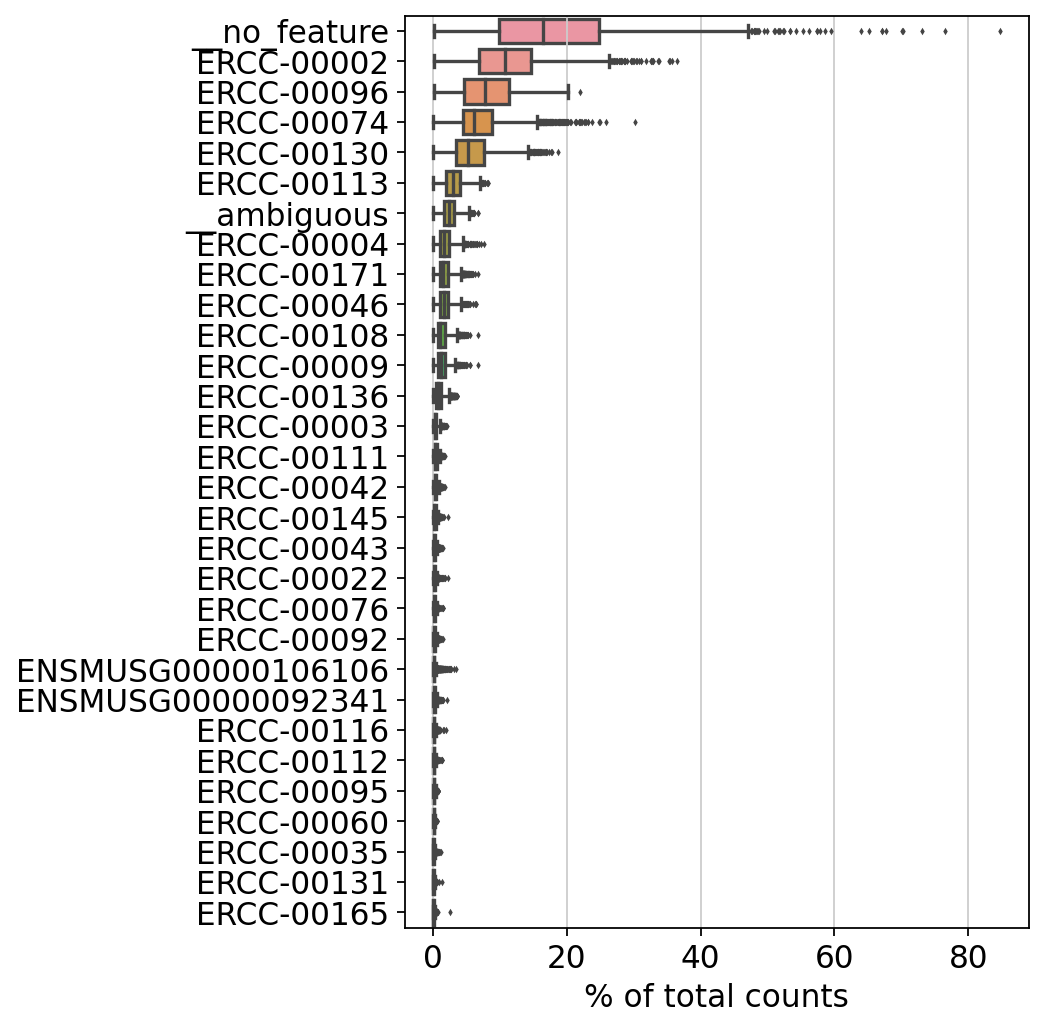

In [144]:
sc.pl.highest_expr_genes(adata)

### Only consider endogeneous transcripts 
Exclude the ERCC from the count matrix in the AnnData object

In [145]:
# identify endogeneous transcripts
transc = []
for i in adata.var_names:
    if i[0:3] == "ENS":
        transc.append(i)

# exlude anything that is not a mouse transcript (ERCC + strange output from the count matrix construction)
adataT = adata[:,transc].copy()

In [146]:
# identify endogeneous transcripts
transc = []
for i in adata.var_names:
    if i.startswith("ERCC"):
        transc.append(i)

# exlude anything that is not a mouse transcript (ERCC + strange output from the count matrix construction)
adataERCC = adata[:,transc].copy()

In [147]:
adataERCC

AnnData object with n_obs × n_vars = 4992 × 92
    obs: 'n_counts', 'batch', 'exp.', 'plate', 'Specie/strain', 'condtition', 'age', 'mice ID', 'Solexa', 'CM number', 'code', 'HiSeq', 'PE', 'column', 'raw', 'indexes', 'index', 'index.1', 'index.2', 'index.3', 'indexes.1', 'LIMS', 'DO number', 'strain', 'ERCC.dilution'
    var: 'length', 'gene_name', 'chromosomes', 'start', 'end'

In [148]:
adataT

AnnData object with n_obs × n_vars = 4992 × 54232
    obs: 'n_counts', 'batch', 'exp.', 'plate', 'Specie/strain', 'condtition', 'age', 'mice ID', 'Solexa', 'CM number', 'code', 'HiSeq', 'PE', 'column', 'raw', 'indexes', 'index', 'index.1', 'index.2', 'index.3', 'indexes.1', 'LIMS', 'DO number', 'strain', 'ERCC.dilution'
    var: 'length', 'gene_name', 'chromosomes', 'start', 'end'

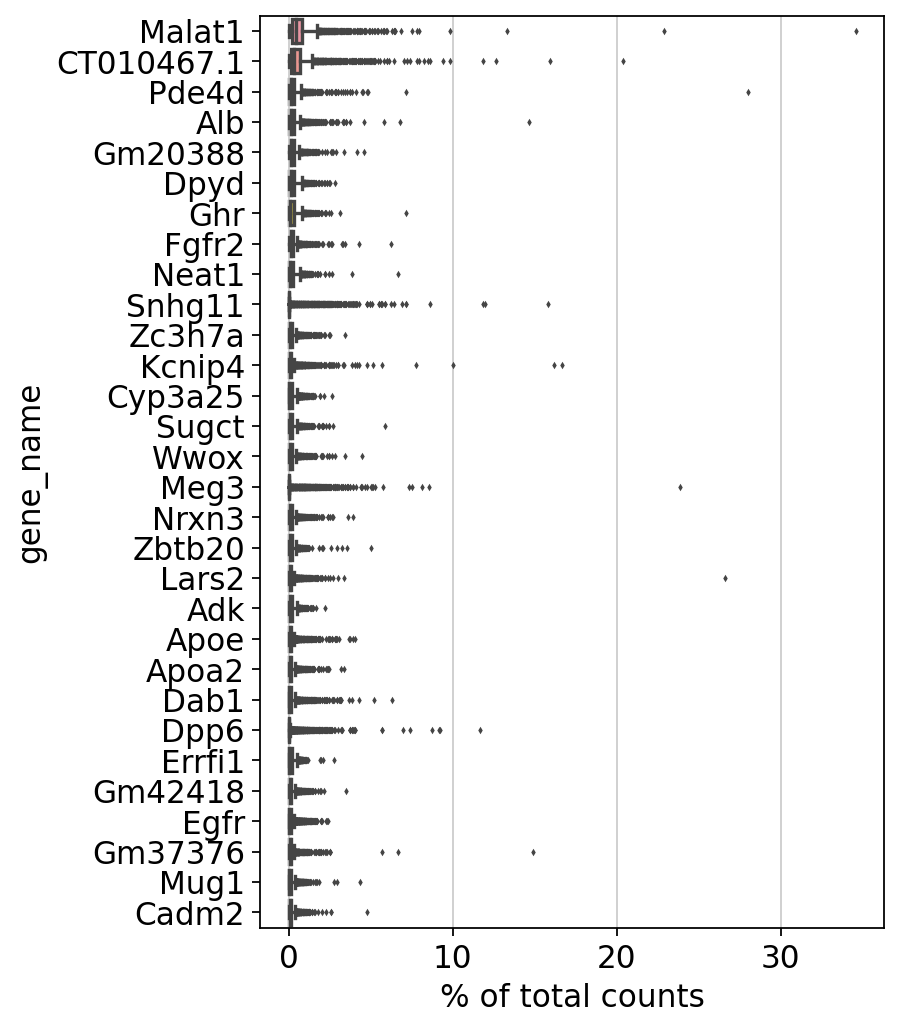

In [151]:
sc.pl.highest_expr_genes(adataT,gene_symbols='gene_name')

# first visualisation

In [152]:
sc.pp.pca(adataT, svd_solver='arpack')

... storing 'exp.' as categorical
... storing 'Specie/strain' as categorical
... storing 'condtition' as categorical
... storing 'age' as categorical
... storing 'mice ID' as categorical
... storing 'Solexa' as categorical
... storing 'CM number' as categorical
... storing 'HiSeq' as categorical
... storing 'PE' as categorical
... storing 'raw' as categorical
... storing 'indexes' as categorical
... storing 'index' as categorical
... storing 'index.1' as categorical
... storing 'index.2' as categorical
... storing 'index.3' as categorical
... storing 'indexes.1' as categorical
... storing 'LIMS' as categorical
... storing 'DO number' as categorical
... storing 'ERCC.dilution' as categorical
... storing 'gene_name' as categorical
... storing 'chromosomes' as categorical


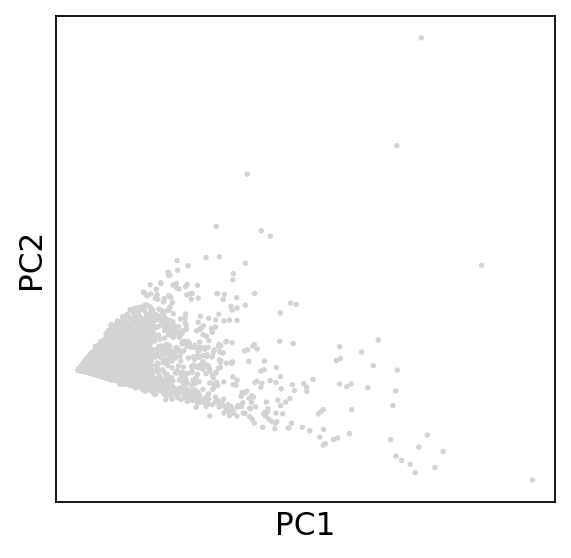

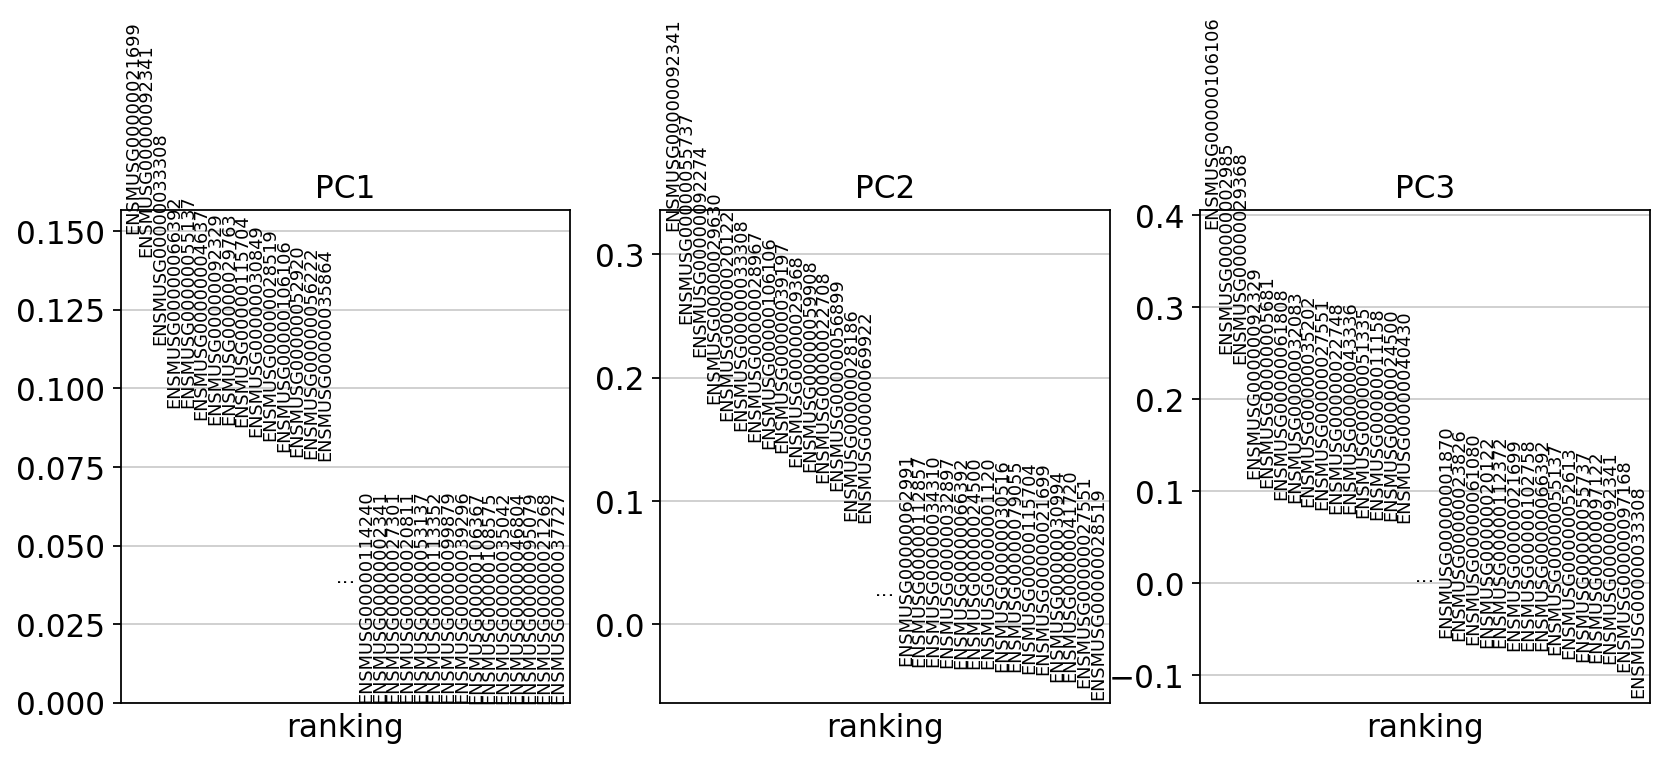

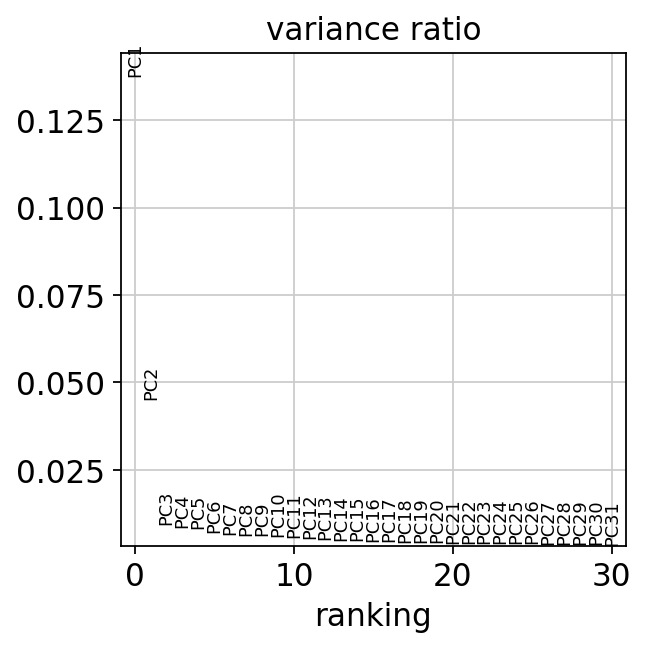

In [153]:
sc.pl.pca_overview(adataT)

In [154]:
sc.pp.neighbors(adataT)
sc.tl.umap(adataT)

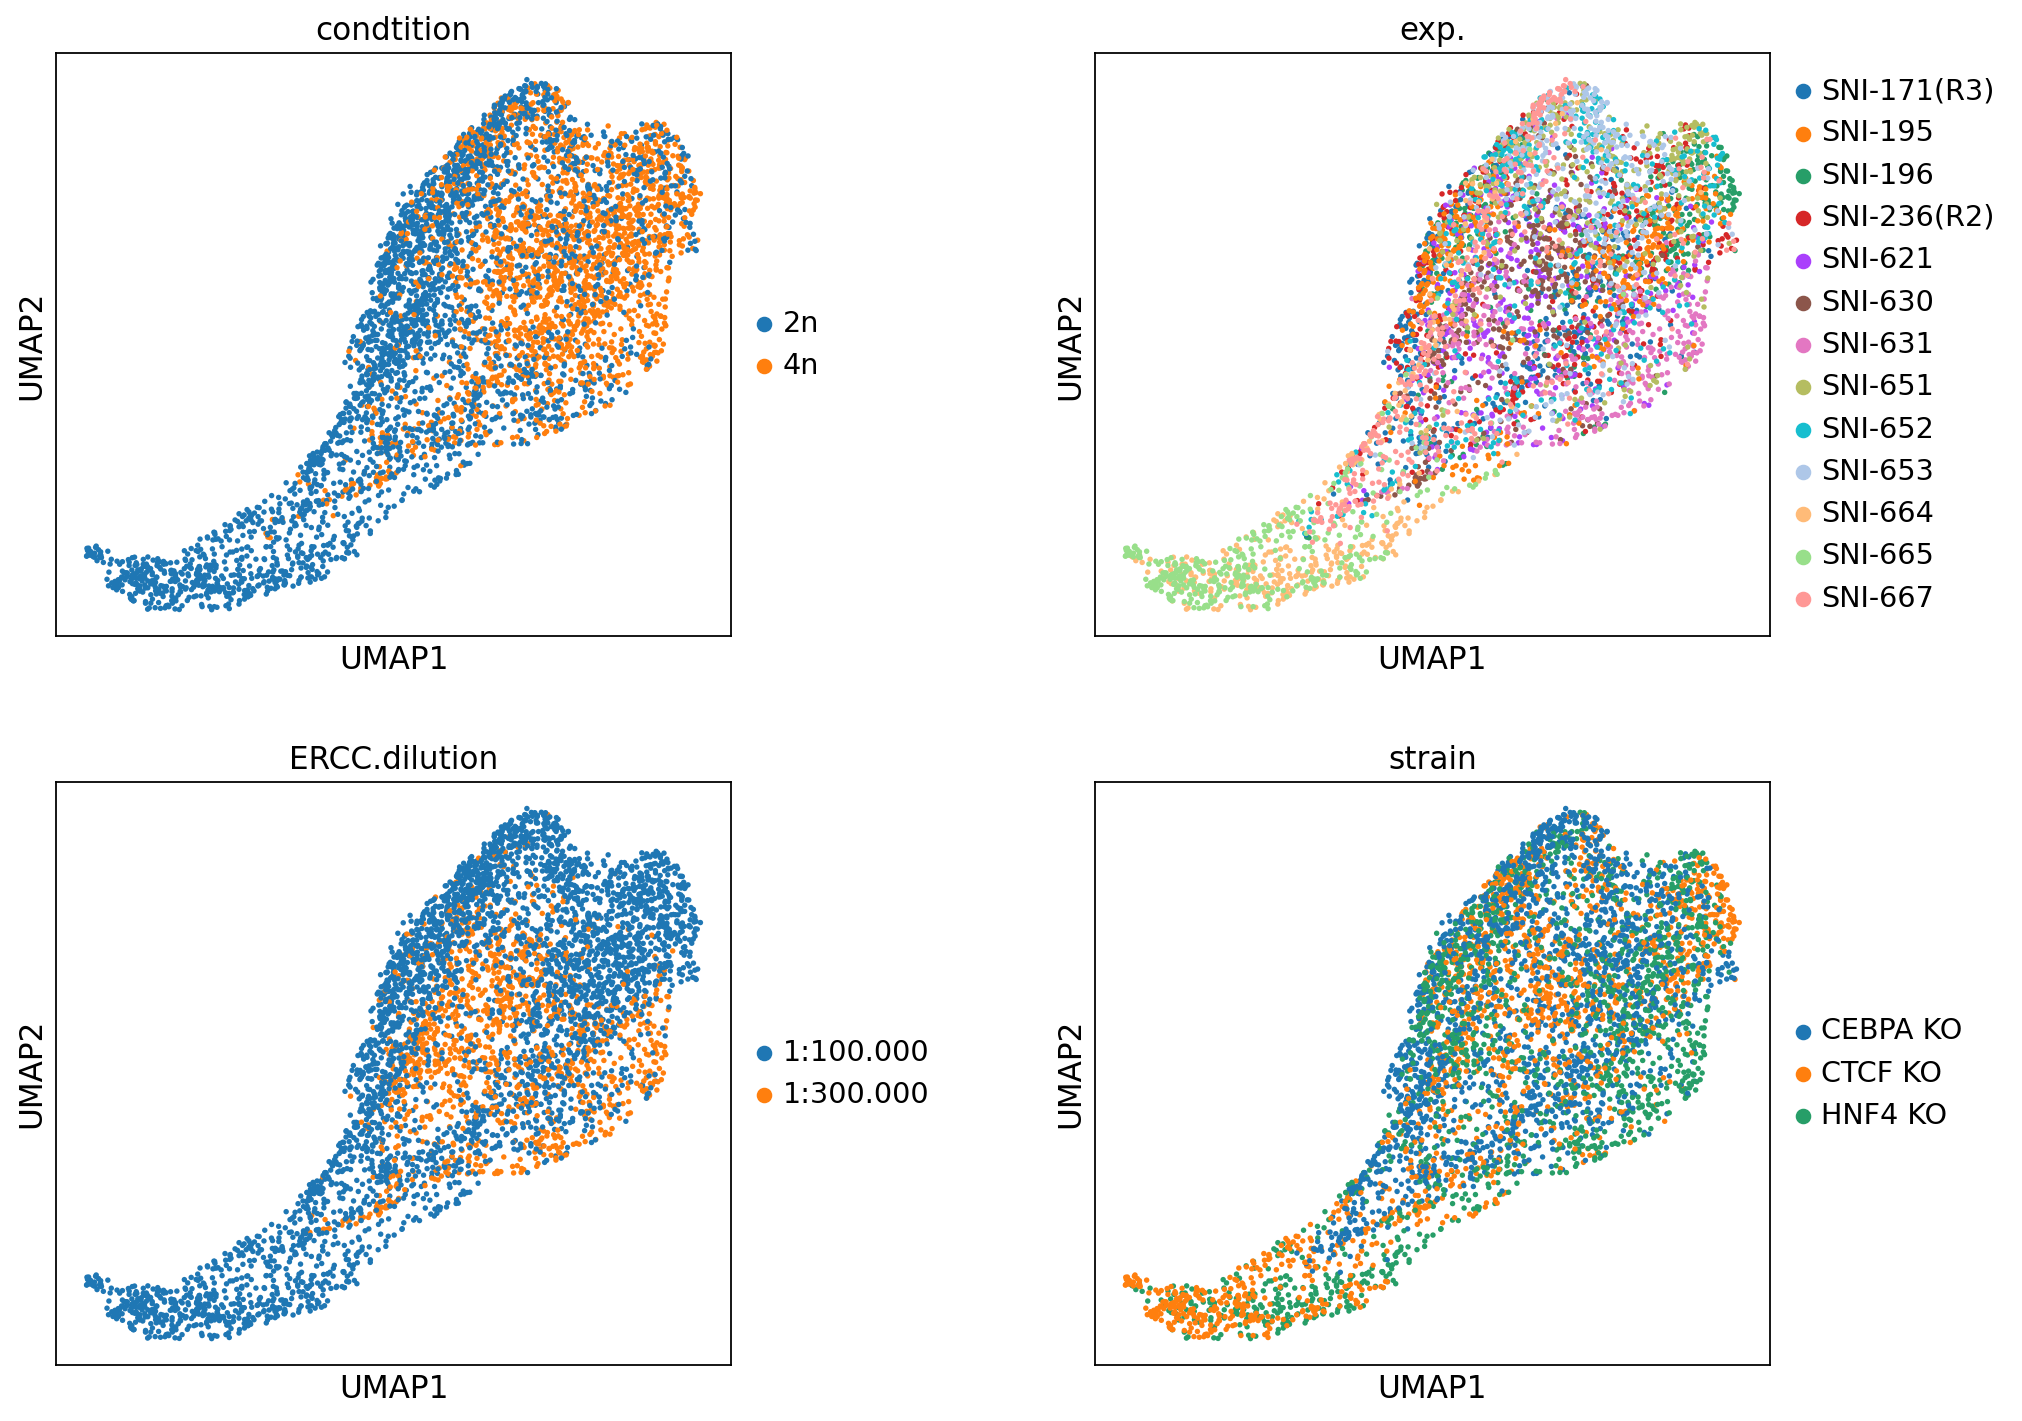

In [157]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adataT, color=["condtition","exp.", "ERCC.dilution", "strain"],
           ncols=2, wspace=0.4, save='_' + today +'_all_cells_raw.pdf')

In [158]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])

In [159]:
adata.obs['n_genes'] = (adata.X>0).sum(axis=1)

In [160]:
adata.obs["n_counts_transcripts"] = np.sum(adataT.X, axis=1)

In [161]:
adata.obs["n_counts_ERCC"] = np.sum(adataERCC.X, axis=1)

In [162]:
adata.obs['percentERCC'] = adata.obs["n_counts_ERCC"]/adata.obs['n_counts']
adata.obs["percentERCC"] = pd.to_numeric(adata.obs["percentERCC"])

In [163]:
adata.obsm['X_umap'] = adataT.obsm['X_umap']

... storing 'exp.' as categorical
... storing 'Specie/strain' as categorical
... storing 'condtition' as categorical
... storing 'age' as categorical
... storing 'mice ID' as categorical
... storing 'Solexa' as categorical
... storing 'CM number' as categorical
... storing 'HiSeq' as categorical
... storing 'PE' as categorical
... storing 'raw' as categorical
... storing 'indexes' as categorical
... storing 'index' as categorical
... storing 'index.1' as categorical
... storing 'index.2' as categorical
... storing 'index.3' as categorical
... storing 'indexes.1' as categorical
... storing 'LIMS' as categorical
... storing 'DO number' as categorical
... storing 'ERCC.dilution' as categorical
... storing 'gene_name' as categorical
... storing 'chromosomes' as categorical


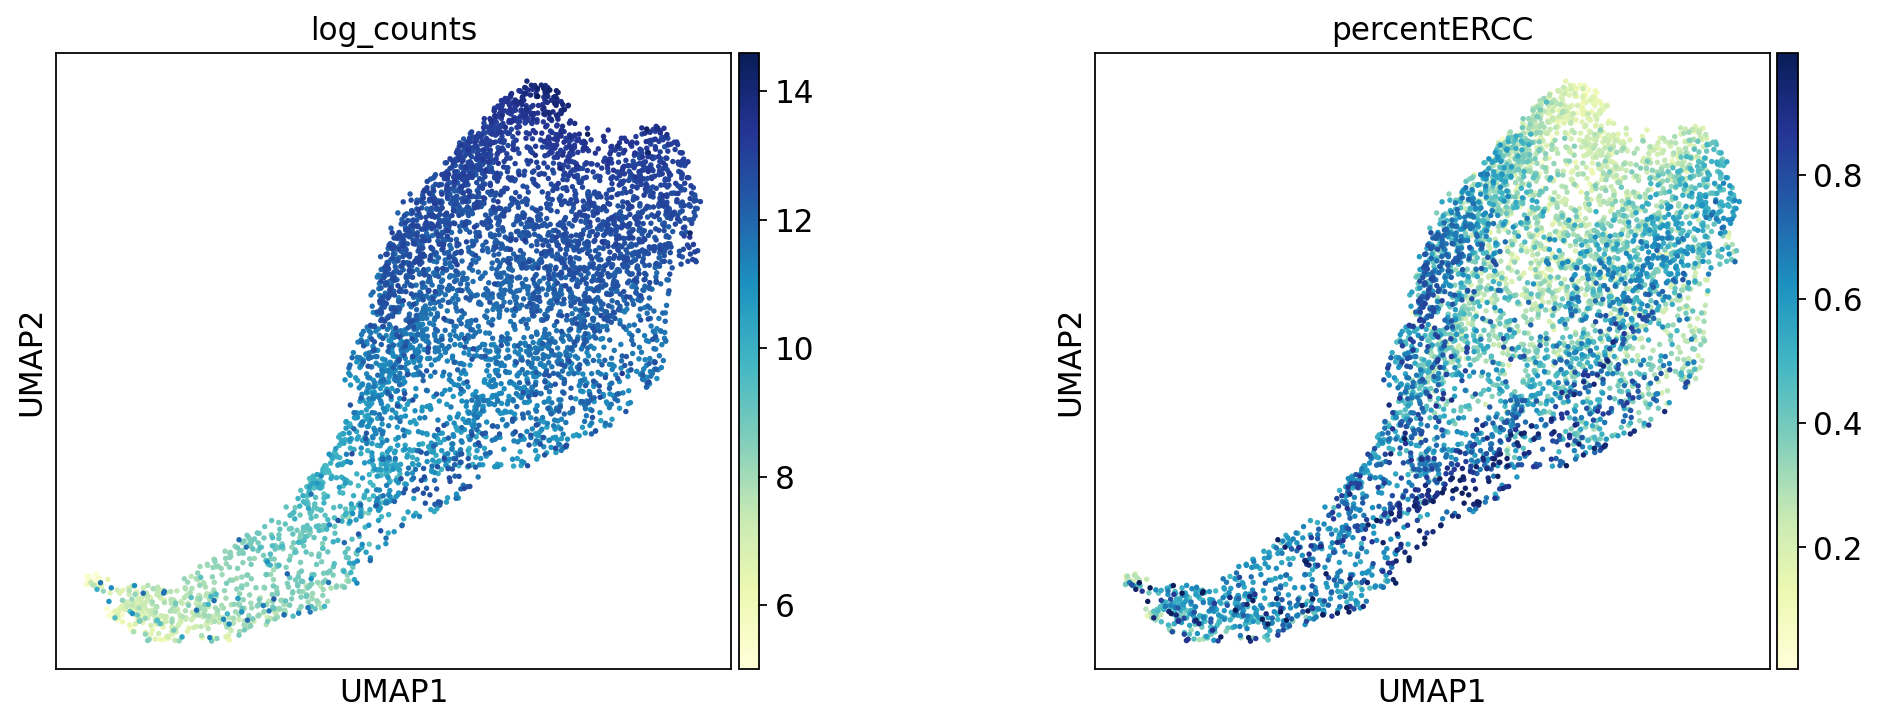

In [164]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=["log_counts","percentERCC"],ncols=2, wspace=0.4, 
           save='_' + today +'_counts_all_cells_raw.pdf')

Trying to set attribute `.uns` of view, copying.


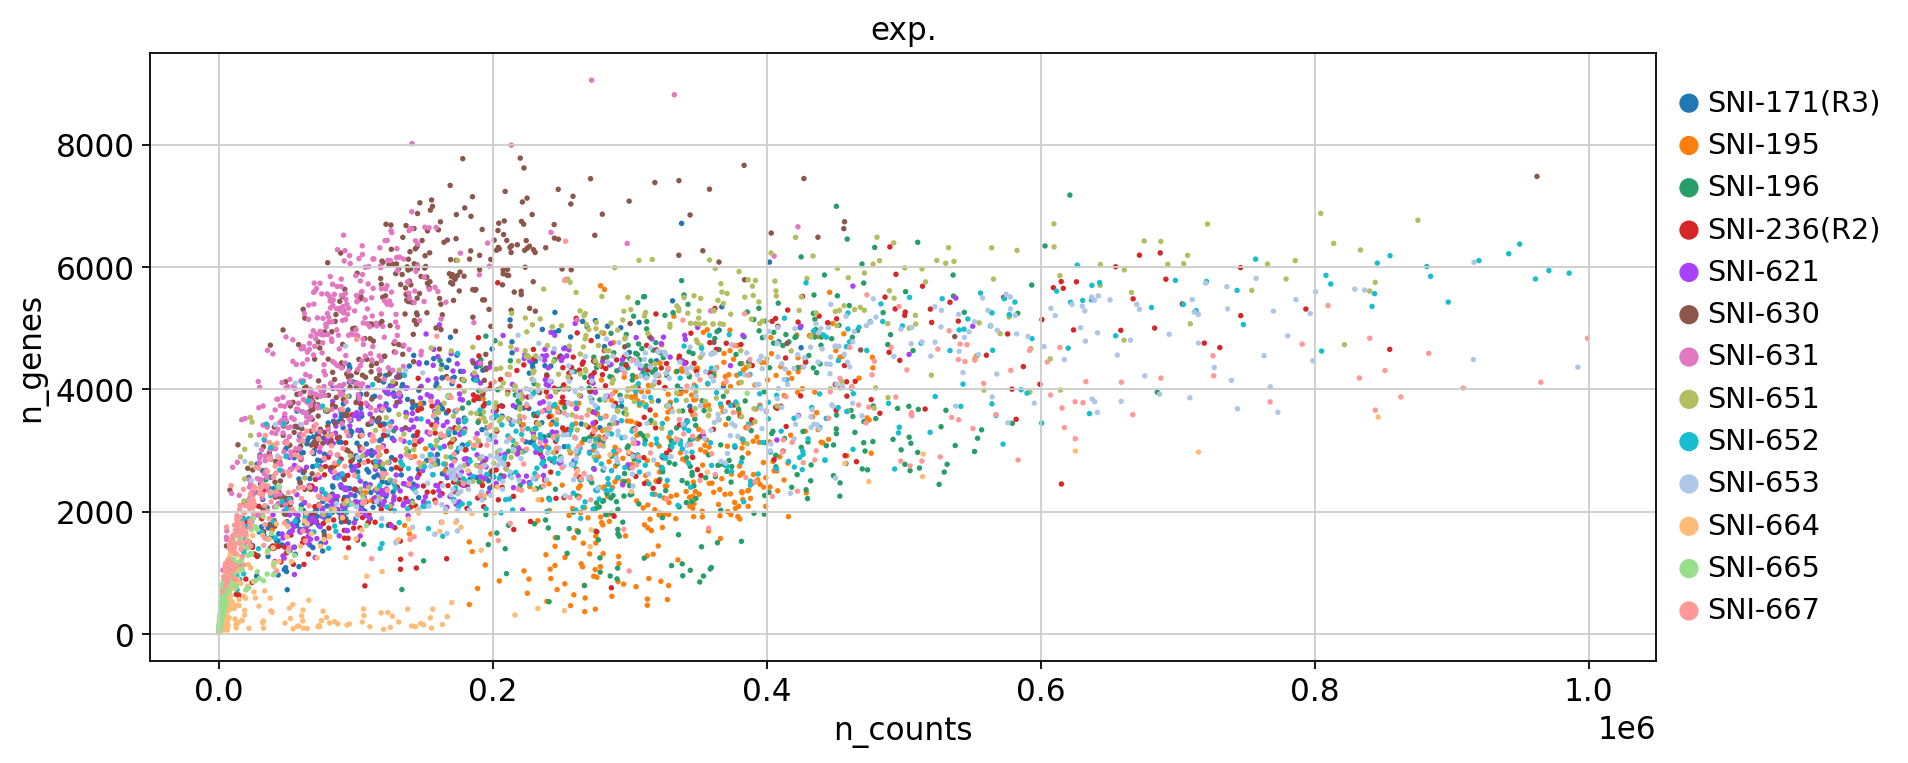

In [165]:
rcParams['figure.figsize']= (10,5)
sc.pl.scatter(adata[adata.obs['n_counts']<1e6], 
              'n_counts', 'n_genes', color='exp.', save='_' + today +'_QC_counts_vs_genes.pdf')

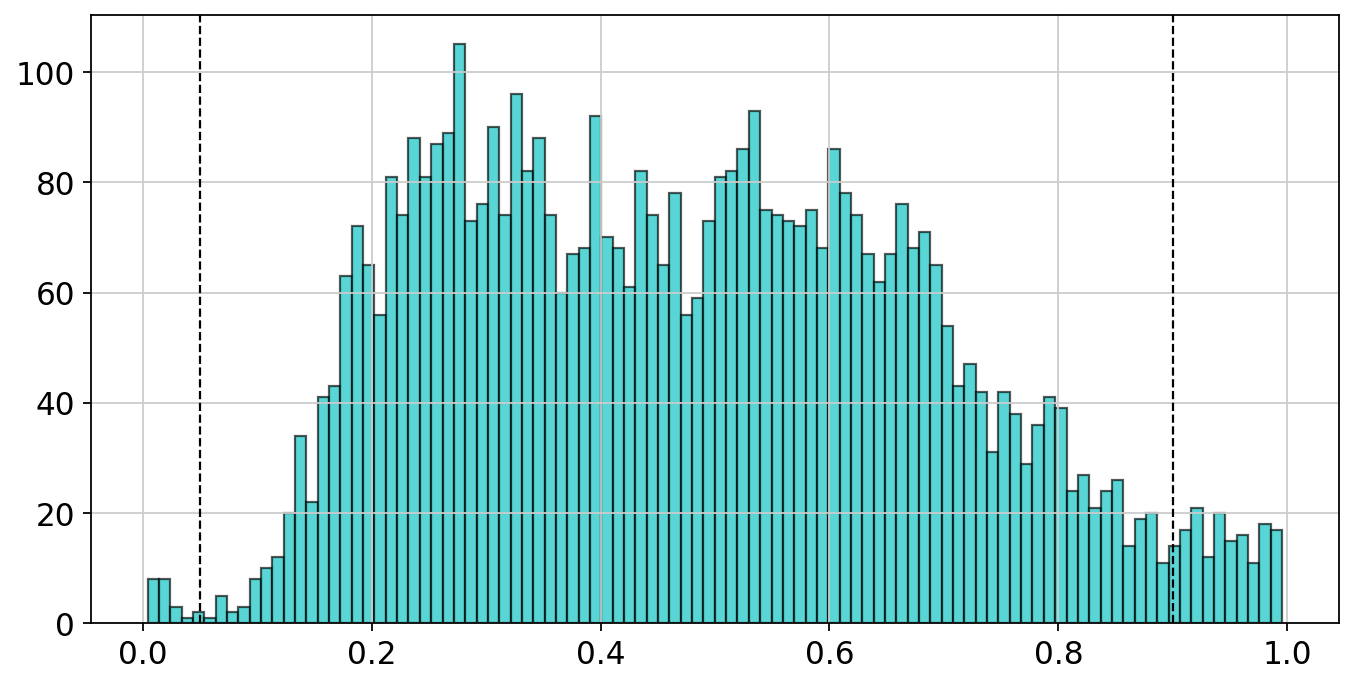

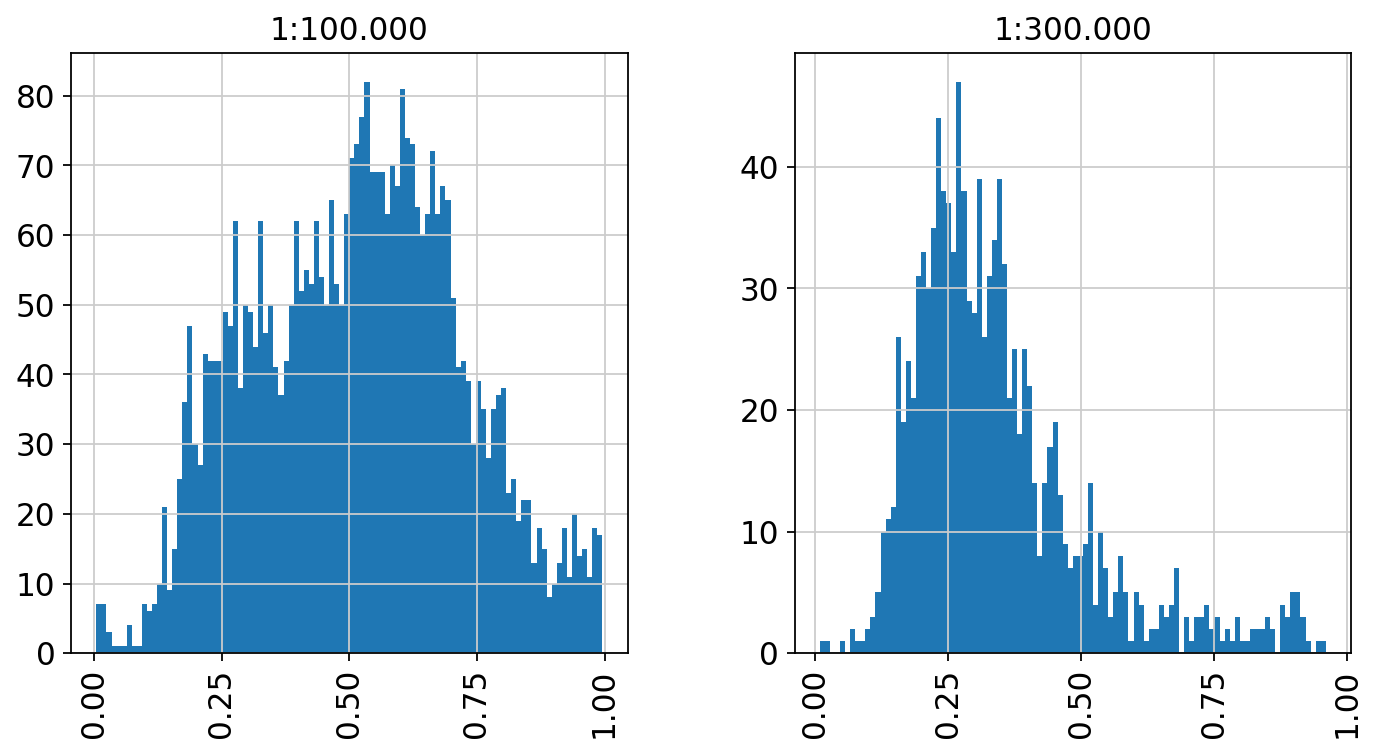

In [166]:
rcParams['figure.figsize']=(10,5)
p = plt.hist(adata.obs["percentERCC"], bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(0.9, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)
plt.savefig('./figures/' + today +'_histogram_percentERCC.pdf')
pd.DataFrame.hist(adata.obs, column="percentERCC", by="ERCC.dilution", bins=int(100))
plt.savefig('./figures/' + today +'_histogram_dilution_percentERCC.pdf')

## Save to file

In [167]:
adata.write(datadir+ '/' + "snRNAseq_mouse_hepatocytes_ko_raw_jan21.h5ad")